In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from xarrayMannKendall import *

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:42245 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

Load reanalysis and CMIP6 multimodel mean

In [4]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [5]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

Load CMIP6 individual models

In [6]:
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_names = list(uas_cmip.keys())

Load region mask

In [7]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

Calculate trends

In [8]:
uas_trends = {}
vas_trends = {}
for k in keys:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})

In [9]:
uas_trends_cmip = {}
vas_trends_cmip = {}
for k in model_names:
    u = uas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends_cmip[k] = MK_class.compute()
    uas_trends_cmip[k] = uas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends_cmip[k] = MK_class.compute()
    vas_trends_cmip[k] = vas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})

Calculate area for weighting

In [10]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['ERA-Interim']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['ERA-Interim'].isel(time = 0)))
for i in range(len(uas['ERA-Interim']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['ERA-Interim']['lat'], 'lon':uas['ERA-Interim']['lon']})

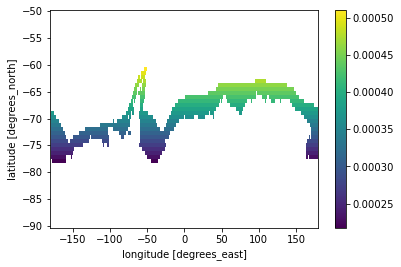

In [17]:
(area/area_total*mask).plot()

In [19]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_names:
    u_ave[k] = (uas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))

In [20]:
ut_ave = {}
vt_ave = {}
for k in keys:
    ut_ave[k] = (uas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_names:
    ut_ave[k] = (uas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))

Put them all together in an xarray to calculate renalaysis mean

In [21]:
u_ave_xarray = u_ave[keys[0]]
v_ave_xarray = v_ave[keys[0]]
for k in keys[1:]+model_names:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = keys+model_names
v_ave_xarray['model'] = keys+model_names

In [22]:
ut_ave_xarray = ut_ave[keys[0]]
vt_ave_xarray = vt_ave[keys[0]]
for k in keys[1:]+model_names:
    ut_ave_xarray = xr.concat([ut_ave_xarray, ut_ave[k]], dim = 'model')
    vt_ave_xarray = xr.concat([vt_ave_xarray, vt_ave[k]], dim = 'model')
ut_ave_xarray['model'] = keys+model_names
vt_ave_xarray['model'] = keys+model_names

In [23]:
u_ave_cmip_sd = u_ave_xarray.sel(model = model_names).std('model')
v_ave_cmip_sd = v_ave_xarray.sel(model = model_names).std('model')

In [24]:
ut_ave_cmip_sd = ut_ave_xarray.sel(model = model_names).std('model')
vt_ave_cmip_sd = vt_ave_xarray.sel(model = model_names).std('model')

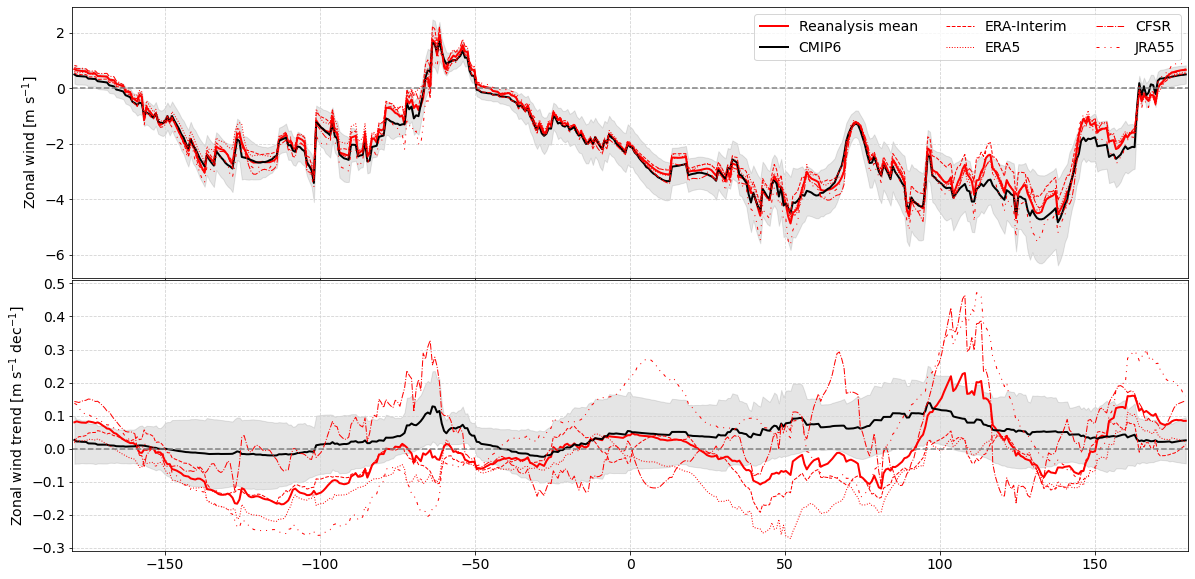

In [27]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax1.set_xlim(-180, 180)
ax2 = plt.subplot(212, sharex = ax1)
fig.subplots_adjust(hspace = 0.01)

ax1.plot(u_ave_xarray['lon'], u_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax1.plot(u_ave_xarray['lon'], u_ave_xarray.sel(model = 'CMIP6'), color = 'k', linewidth = 2, label = 'CMIP6')
ax1.fill_between(u_ave_xarray['lon'], u_ave_xarray.sel(model = 'CMIP6')-u_ave_cmip_sd, 
                 u_ave_xarray.sel(model = 'CMIP6')+u_ave_cmip_sd, color = 'k', alpha = 0.1)

ax2.plot(ut_ave_xarray['lon'], 10*ut_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2)
ax2.plot(ut_ave_xarray['lon'], 10*ut_ave_xarray.sel(model = 'CMIP6'), color = 'k', linewidth = 2)
ax2.fill_between(ut_ave_xarray['lon'], 10*(ut_ave_xarray.sel(model = 'CMIP6')-ut_ave_cmip_sd), 
                 10*(ut_ave_xarray.sel(model = 'CMIP6')+ut_ave_cmip_sd), color = 'k', alpha = 0.1)

for k, ls in zip(keys[:-1], ['--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]):
    ax1.plot(u_ave_xarray['lon'], u_ave_xarray.sel(model = k), color = 'r', linestyle = ls, linewidth = 1, label = k)
    ax2.plot(ut_ave_xarray['lon'], 10*ut_ave_xarray.sel(model = k), color = 'r', linestyle = ls, linewidth = 1)

ax1.grid(linestyle = '--', color = 'lightgrey')
ax2.grid(linestyle = '--', color = 'lightgrey')
ax1.axhline(y = 0, linestyle = '--', color = 'grey')
ax2.axhline(y = 0, linestyle = '--', color = 'grey')
ax1.set_ylabel('Zonal wind [m s$^{-1}$]')
ax2.set_ylabel('Zonal wind trend [m s$^{-1}$ dec$^{-1}$]')
ax1.legend(ncol = 3)

plt.savefig('../results/v2/fig3a.jpg', bbox_inches = 'tight')

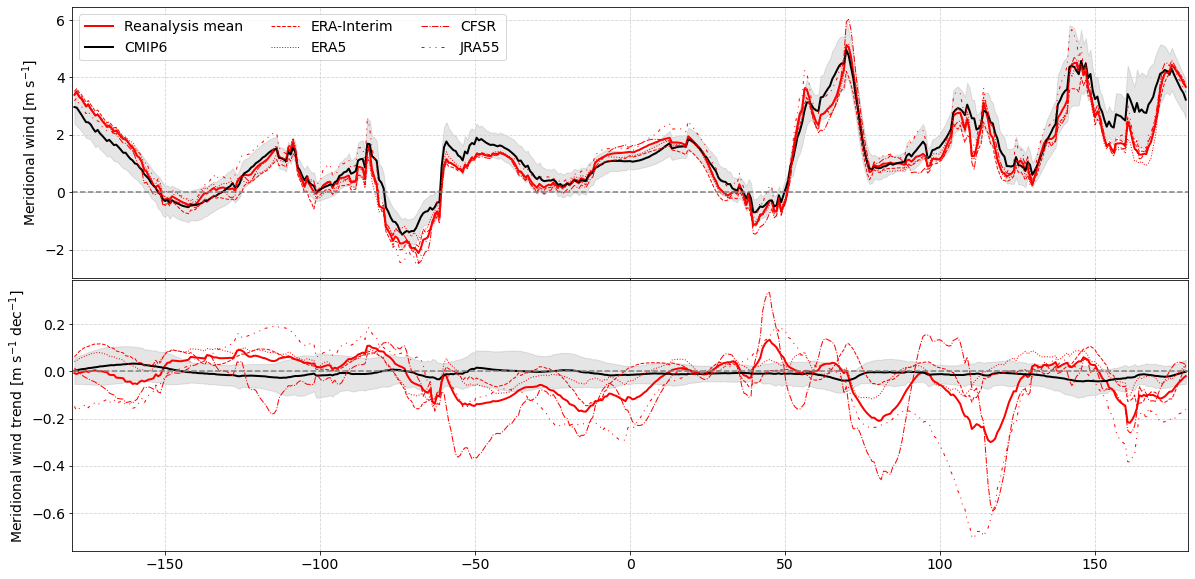

In [29]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax1.set_xlim(-180, 180)
ax2 = plt.subplot(212, sharex = ax1)
fig.subplots_adjust(hspace = 0.01)

ax1.plot(v_ave_xarray['lon'], v_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2, label = 'Reanalysis mean')
ax1.plot(v_ave_xarray['lon'], v_ave_xarray.sel(model = 'CMIP6'), color = 'k', linewidth = 2, label = 'CMIP6')
ax1.fill_between(v_ave_xarray['lon'], v_ave_xarray.sel(model = 'CMIP6')-v_ave_cmip_sd, 
                 v_ave_xarray.sel(model = 'CMIP6')+v_ave_cmip_sd, color = 'k', alpha = 0.1)

ax2.plot(vt_ave_xarray['lon'], 10*vt_ave_xarray.sel(model = keys[:-1]).mean('model'), color = 'r', linewidth = 2)
ax2.plot(vt_ave_xarray['lon'], 10*vt_ave_xarray.sel(model = 'CMIP6'), color = 'k', linewidth = 2)
ax2.fill_between(vt_ave_xarray['lon'], 10*(vt_ave_xarray.sel(model = 'CMIP6')-vt_ave_cmip_sd), 
                 10*(vt_ave_xarray.sel(model = 'CMIP6')+vt_ave_cmip_sd), color = 'k', alpha = 0.1)

for k, ls in zip(keys[:-1], ['--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]):
    ax1.plot(v_ave_xarray['lon'], v_ave_xarray.sel(model = k), color = 'r', linestyle = ls, linewidth = 1, label = k)
    ax2.plot(vt_ave_xarray['lon'], 10*vt_ave_xarray.sel(model = k), color = 'r', linestyle = ls, linewidth = 1)

ax1.grid(linestyle = '--', color = 'lightgrey')
ax2.grid(linestyle = '--', color = 'lightgrey')
ax1.axhline(y = 0, linestyle = '--', color = 'grey')
ax2.axhline(y = 0, linestyle = '--', color = 'grey')
ax1.set_ylabel('Meridional wind [m s$^{-1}$]')
ax2.set_ylabel('Meridional wind trend [m s$^{-1}$ dec$^{-1}$]')
ax1.legend(ncol = 3)

plt.savefig('../results/v2/fig3b.jpg', bbox_inches = 'tight')